# 第三組: 事件分析 -「蕾神之鎚」VS「宏慌之力」 王力宏婚變大戰
**組員:** 黃子源、孫亦農、黃弘瑋、劉雨瑈、林元雅、林妤姍<br>
**Date created:** 2021/12/24<br>
**Last modified:** 2021/12/24<br>

## 大綱
1. 套件說明
1. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 Jieba中文斷詞、匯入字典
    + 2.4 去除停用字
1. LDA 主題模型
    + 3.1 訓練LDA模型
    + 3.2 查看 LDA 主題代表字
    + 3.3 查看 LDA 模型指標
    + 3.4 透過指標找出最佳主題數
1. LDA 視覺化呈現
    + 4.1 產生 LDAvis 結果
    + 4.2 查看 Document 主題時間上分佈
1. 社群網路圖
    + 5.1 基本網路圖
    + 5.2 資料篩選
    + 5.3 以日期篩選社群
    + 5.4 以主題篩選社群
    + 5.5 使用者是否受到歡迎

## 1. 套件說明
本次實作過程中使用到的相關套件。
+ pandas:提供高效能、簡易使用的資料格式與資料處理的函數。
+ jieba:中文斷詞套件
+ re:正規化表達式套件
+ matplotlib:繪圖工具
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件
+ networkx: 網絡圖建構、繪製工具。

In [ ]:
#安裝pyLDAvis套件(安裝完後要Restart Runtime，不然會出錯)
!pip install pyLDAvis

In [ ]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np
import IPython
import networkx as nx
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 移至指定路徑
%cd /content/drive/Shareddrives/社媒讀書會/第三次讀書會

/content/drive/Shareddrives/社媒讀書會/第三次讀書會


In [ ]:
# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

In [ ]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# cloab 字體設定
#!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理
+ 資料收集：使用中山管院文字分析平台，來收集文本資料。
+ 資料清理：將文本內容轉為正規語句，例如：統一標點符號、去除特定標籤等等。
+ 斷詞：使用工具區分文章中的詞彙，以便於進行分析。
+ 去除停用字：將與分析無關的詞彙去除，例如：語助詞、連接詞等等，來避免影響後續分析結果。

### 2.1 基本資料介紹
+ 資料來源: PTT Gossip版 2021-12-14 ~ 2021-12-24 所有文章&評論
- 資料集： 
  - `raw_data/PTT_Gossip_Lee_articleMetaData.csv`
  - `raw_data/PTT_Gossip_Lee_articleReviews.csv`
- 關鍵字：王力宏、李靚蕾、蕾神、王大中、BY2、Yumi..等
- 資料時間：2021-12-14 ~ 2021-12-24

本次文本分析主要針對以下方向：
1. 使用LDA對此事件進行主題模型分析
2. 繪製社群網路圖

In [ ]:
# 匯入資料
MetaData = pd.read_csv('./raw_data/PTT_Gossip_Lee_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/PTT_Gossip_Lee_articleReviews.csv', encoding='UTF-8')

In [ ]:
print(f"PTT八卦版共有 {MetaData.shape[0]} 篇文章") 
print(f"PTT八卦版共有 {Reviews.shape[0]} 篇評論")

PTT八卦版共有 4063 篇文章
PTT八卦版共有 202130 篇評論


In [ ]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]王力宏結束8年婚姻,2021/12/14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14,5,3,剛剛蘋果新聞跳出來的\n\n這是真的嗎@@?\n\n我國中女同學超哈他的 真的太驚訝嚕 應該是真的
1,[新聞]王力宏結束8年婚姻！ 被爆已辦妥離婚手,2021/12/14,23:27:46,https://www.ptt.cc/bbs/Gossiping/M.1639524469....,qq326,Gossiping,349,221,26,1.媒體來源:\n蘋果新聞網\n\n2.記者署名:\n(娛樂中心/台北報導)\n\n3.完整...
2,[問卦]為什麼王力宏一直被傳出是同性戀??,2021/12/14,23:33:01,https://www.ptt.cc/bbs/Gossiping/M.1639524783....,pipiboygay,Gossiping,67,36,4,奇怪，為什麼王力宏一直被外界傳說是同性戀\n\n即使他都已經結婚生子，小孩都三個了\n\n這...


In [ ]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]王力宏結束8年婚姻,2021/12/14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,TWilde,推,2021-12-15 07:20:00,:花田裡犯了錯
1,[問卦]王力宏結束8年婚姻,2021/12/14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,kutkin,推,2021-12-15 07:20:00,:乾就說他是鈣吧
2,[問卦]王力宏結束8年婚姻,2021/12/14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,yoshilin,→,2021-12-15 07:21:00,:不知離婚要付多少錢?


**查看王力宏事件的相關文章在時間上的數量走勢** <br>
+ 將資料中「artDate」(報導日期)groupby起來，並計算數量。
+ 日期資料轉換為日期格式。

In [ ]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': MetaData.groupby('artDate').size().index,
    'count': MetaData.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

+ 觀察折線圖，可以發現事件的相關文章在 12/15 過後數量有增加的趨勢。(12月15日，王力宏證實和李靚蕾離婚)
+ 12/18 討論聲量達到高峰 (12月17日深夜，李靚蕾長文爆料王力宏出軌、召妓、私生活混亂)

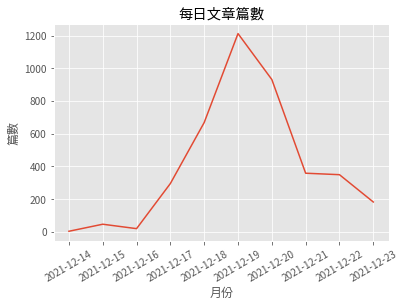

In [ ]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每日文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

### 2.2 資料清理
+ 去除NA值
+ 移除PTT會出現的格式用字
+ 去除不是中文、英文、數字的字詞

In [ ]:
# 移除內容為na值的資料
MetaData.dropna(subset = ["sentence"], inplace=True)
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
# 去除非中文、英文、數字的字詞
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa50-9A-Za-z]+', '', x))

# 將資料轉為string格式
MetaData['sentence'] = MetaData.sentence.apply(lambda x: str(x))

In [ ]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14,5,3,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的
1,[新聞]王力宏結束8年婚姻！ 被爆已辦妥離婚手,2021-12-14,23:27:46,https://www.ptt.cc/bbs/Gossiping/M.1639524469....,qq326,Gossiping,349,221,26,1蘋果新聞網2娛樂中心台北報導3王力宏結束8年婚姻被爆已辦妥離婚手續4金曲歌王王力宏驚傳和李...
2,[問卦]為什麼王力宏一直被傳出是同性戀??,2021-12-14,23:33:01,https://www.ptt.cc/bbs/Gossiping/M.1639524783....,pipiboygay,Gossiping,67,36,4,奇怪為什麼王力宏一直被外界傳說是同性戀即使他都已經結婚生子小孩都三個了這個傳聞都始終沒有消失...


### 2.3 Jieba中文斷詞、匯入字典
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from /content/drive/Shareddrives/社媒讀書會/第三次讀書會/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u2413a48158c7dc731947ec19606e5bf0.cache
Loading model cost 1.482 seconds.
Prefix dict has been built successfully.


In [ ]:
# 資料進行斷詞，為list的格式
data = MetaData.copy()
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))
token_df.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,wordlist
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14,5,3,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的,"[剛剛, 蘋果新聞, 跳, 出來, 的, 這是, 真的, 嗎, 我國, 中, 女同學, 超哈..."
1,[新聞]王力宏結束8年婚姻！ 被爆已辦妥離婚手,2021-12-14,23:27:46,https://www.ptt.cc/bbs/Gossiping/M.1639524469....,qq326,Gossiping,349,221,26,1蘋果新聞網2娛樂中心台北報導3王力宏結束8年婚姻被爆已辦妥離婚手續4金曲歌王王力宏驚傳和李...,"[1, 蘋果新聞網, 2, 娛樂中心, 台北, 報導, 3, 王力宏, 結束, 8, 年, ..."
2,[問卦]為什麼王力宏一直被傳出是同性戀??,2021-12-14,23:33:01,https://www.ptt.cc/bbs/Gossiping/M.1639524783....,pipiboygay,Gossiping,67,36,4,奇怪為什麼王力宏一直被外界傳說是同性戀即使他都已經結婚生子小孩都三個了這個傳聞都始終沒有消失...,"[奇怪, 為, 什麼, 王力宏, 一直, 被, 外界, 傳說, 是, 同性戀, 即使, 他,..."


### 2.4 去除停用字

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>
兩種方式： 1.匯入檔案 2.參數形式手動加入

In [ ]:
stopwords = []

#新增stop words
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]
    
# 參數形式手動加入停用字
user_stop = ["真的"]
for i in user_stop:
    stopwords.append(i)

In [ ]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [ ]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(1)

remove_stopwords 為 wordlist 移除停用字後的結果：


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,wordlist,remove_stopwords
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14,5,3,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的,"[剛剛, 蘋果新聞, 跳, 出來, 的, 這是, 真的, 嗎, 我國, 中, 女同學, 超哈...","[剛剛, 蘋果新聞, 這是, 我國, 女同學, 超哈, 驚訝]"


## 3. LDA 主題模型

### 3.1 訓練 LDA 模型

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [ ]:
token_data = token_df['remove_stopwords'].tolist()

In [ ]:
for i in range(2,5):
    print("第 " + str(i+1) + " 篇文章前5個字：")
    for j in range(0,5):
        print(token_data[i][j], end=' ')
    print('\n')

第 3 篇文章前5個字：
奇怪 王力宏 外界 同性戀 結婚 

第 4 篇文章前5個字：
兩人 會作 詞曲 王力宏 唱歌 

第 5 篇文章前5個字：
早就 預言 力宏 八年 甲方乙方 



In [ ]:
#id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(33901 unique tokens: ['剛剛', '女同學', '我國', '蘋果新聞', '超哈']...)


+ 將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
+ 每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

In [ ]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [ ]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=3, # 生成幾個主題數
    random_state=1500, # 亂數
    iterations = 2500, # 每個文章訓練的次數
    passes=10, # 模型訓練次數
)

### 3.2 查看 LDA 主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [ ]:
# 每個主題重要的前十個關鍵字
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.027*"王力宏" + 0.015*"阿妹" + 0.008*"台灣" + 0.007*"有沒有" + 0.007*"力宏" + 0.007*"八卦" + 0.006*"中國" + 0.005*"專輯" + 0.004*"蕾神" + 0.004*"歌手"')
(1, '0.022*"王力宏" + 0.007*"離婚" + 0.007*"李靚蕾" + 0.006*"小孩" + 0.005*"力宏" + 0.005*"孩子" + 0.004*"女方" + 0.004*"結婚" + 0.004*"蕾神" + 0.003*"關係"')
(2, '0.013*"蕾神" + 0.011*"彈頭" + 0.011*"Yumi" + 0.010*"王力宏" + 0.008*"離婚" + 0.007*"By2" + 0.007*"小孩" + 0.007*"李靚蕾" + 0.007*"發文" + 0.006*"黑人"')


根據每個主題的詞彙分佈來猜測，可分為以下主題：

+ 主題一：王力宏被爆之前約看電影的緋聞對象是張惠妹，也曾為阿妹的專輯寫歌、合唱。
+ 主題二：王力宏與李靚蕾(蕾神)的離婚消息，以及雙方之間孩子的紛爭，李靜蕾長文爆料王力宏愛小孩，被逼5年生三胎。
+ 主題三：捲入離婚大戰的相關人物討論，例如:王力宏被爆料婚前婚後出軌By2 Yumi、南拳媽媽彈頭順勢批評和爆料黑人陳建州。


### 3.3 查看 LDA 模型指標
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -1.995005851447946


In [ ]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -9.466218191018639


### 3.4 透過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 3 來做分析。

In [ ]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-9.495615,13301.275639
1,4,-9.616087,15004.228258
2,6,-9.663390,15731.021210
3,8,-9.674010,15898.970557


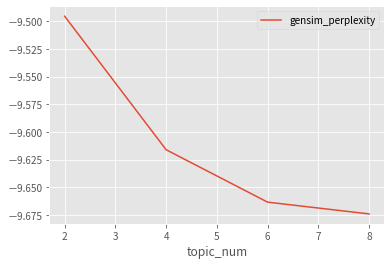

In [ ]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-9.495615,13301.275639
1,4,-9.616087,15004.228258
2,6,-9.663390,15731.021210
3,8,-9.674010,15898.970557


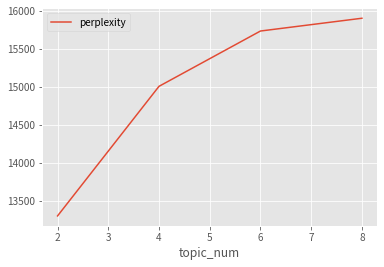

In [ ]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

## 4. LDA 視覺化呈現

### 4.1 產生 LDAvis 結果

以下用主題數 3 來做 LDAvis 的結果範例:

In [ ]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'ldaVis.html')
IPython.display.HTML(filename= "ldaVis.html")

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### 4.2 查看 Document 主題時間上分佈

以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [ ]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.8929278, 0.064342864, 0.04272934], [0.0357279, 0.8834987, 0.08077338], [0.020691989, 0.7955165, 0.18379158]]


In [ ]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [ ]:
# 將 artDate 轉換為 Python 日期時間
MetaData.artDate = pd.to_datetime(MetaData['artDate'])
Reviews.artDate = pd.to_datetime(Reviews['artDate'])
data.artDate = pd.to_datetime(data['artDate'])

In [ ]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic = date_topic.groupby(['artDate','topic']).sum().reset_index()

In [ ]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate')
date_df

,topic0,topic1,topic2
artDate,,,
2021-12-14,1.0,2.0,0.0
2021-12-15,10.0,32.0,4.0
2021-12-16,4.0,13.0,2.0
2021-12-17,112.0,175.0,8.0
2021-12-18,244.0,404.0,19.0
2021-12-19,367.0,779.0,66.0
2021-12-20,226.0,652.0,53.0
2021-12-21,103.0,233.0,22.0
2021-12-22,101.0,203.0,44.0


可以看到在不同時間點，特定主題談論篇幅的多寡

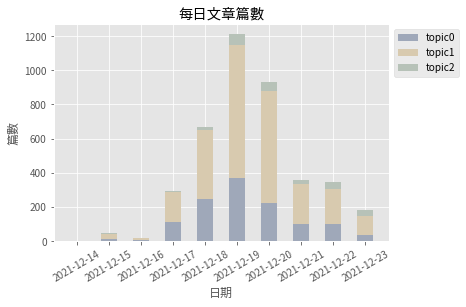

In [ ]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5"]
column = ['topic0', 'topic1', 'topic2']
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=0.5)     


plt.title('每日文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

根據上面的圖表，搭配時事推估：
+ Topic 1 (離婚大戰) 的討論聲量於 12月17日~19日處於顛峰，19日後討論大幅下滑。
+ Topic 2 (事件相關人物討論: Yumi、彈頭) 於12月18日~23日的討論聲量有增加的趨勢，推測是因為發生許多延伸事件:
  + Yumi支線:
    + 18日，網友爆料王力宏與BY2 Yumi的地下情，Yumi報警控網友誹謗，並貼出報案單佐證，然而同日又被李靚蕾反駁
    + 19日晚間，李靚蕾再次重砲反擊，並曝光Yumi將通訊軟體Whatsapp頭貼換成裸照的照片
    + 22日上午，網友驚傳Yumi吞藥輕生
  + 彈頭支線:
    + 22日，南拳媽媽彈頭發文批評黑人陳建州
    + 23日，李妍瑾參戰，爆料曾被彈頭約砲，2人隔空筆戰

In [ ]:
#轉換成比例
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2

for i in range(0,3):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,sum
artDate,,,,
2021-12-14,0.333333,0.666667,0.000000,3.0
2021-12-15,0.217391,0.695652,0.086957,46.0
2021-12-16,0.210526,0.684211,0.105263,19.0
2021-12-17,0.379661,0.593220,0.027119,295.0
2021-12-18,0.365817,0.605697,0.028486,667.0
2021-12-19,0.302805,0.642739,0.054455,1212.0
2021-12-20,0.242750,0.700322,0.056928,931.0
2021-12-21,0.287709,0.650838,0.061453,358.0
2021-12-22,0.290230,0.583333,0.126437,348.0


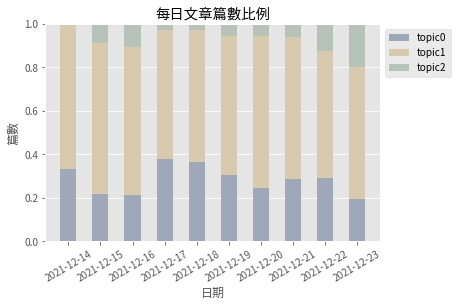

In [ ]:
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=0.5)

plt.title('每日文章篇數比例') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

+ Topic 0：王力宏被爆之前約看電影的緋聞對象是張惠妹，也曾為阿妹的專輯寫歌、合唱。
+ Topic 1：王力宏與李靚蕾(蕾神)的離婚消息，李靜蕾長文爆料王力宏愛小孩，被逼5年生三胎。
+ Topic 2：捲入離婚大戰的相關人物討論，例如:王力宏被爆料婚前婚後出軌By2 Yumi、南拳媽媽彈頭順勢批評和爆料黑人陳建州。

根據上面的圖表，搭配時事推估：
+ Topic 2 的比例於18日以後逐漸增加，推測是因為 Yumi、彈頭的案件不斷延燒、出現新劇情。

#### 查看三個主題的內容，是否符合預測。

In [ ]:
## 主題一: 張惠妹
data[(data["topic"]==0)&(data["artTitle"].str.contains("張惠妹|阿妹"))][["artTitle","sentence","topic"]].sample(n=5)

,artTitle,sentence,topic
3596,[問卦]王力宏跟張惠妹有傳過誹聞?,剛剛新聞說20年前王力宏跟張惠妹有傳過緋聞蕾神之槌有說看電影的時候誹聞女友坐在後面到底是不是...,0
4003,[問卦]王力宏、張惠妹、李靚蕾等人的時間軸,1995年12月19日王力宏在19歲發行首張專輯情敵貝多芬1996年7月阿妹在張雨生的兩伊戰...,0
3212,[問卦]是說力宏跟舒淇阿妹到底有沒有過,一直印象中都是講緋聞但就不知道到底有沒有真的在一起然候那時候只要講到這事大家就會說煙霧彈啦力...,0
3933,Re:[新聞]張惠妹戀王力宏超切心！ 2件事讓她看清,只有我覺得這段是唱我選擇忘記力轟嗡嗡總覺得不是巧合尤其仔細聽這整張專輯沒有其他地方有用到齁這...,0
3558,[問卦]張惠妹20年前pr值多少,20年前張惠妹已經是有好幾張暢銷專輯的歌手也算是滿漂亮的對比下王力宏才剛開始紅張惠妹20年前...,0


In [ ]:
## 主題二: 王力宏、李靜蕾離婚大戰、孩子相關討論
data[(data["topic"]==1)&(data["artTitle"].str.contains("離婚|小孩|孩子"))][["artTitle","sentence","topic"]].sample(n=5)

,artTitle,sentence,topic
3953,Re:[問卦]王力宏確定李靚蕾生的三個小孩都他的?,就你可以支持女方別人就想支持男方女說男約砲男為何不能說女討客兄女受荷爾蒙影響沒性慾可以說男方...,1
144,Re:[新聞]快訊／李靚蕾深夜長文揭離婚內幕 控王力,真的不能看外表沒想到某位優質偶像看起來乖乖有氣質結果是約X與招X請看前妻文有個八卦強者我朋友...,1
4048,[問卦]離婚前一天徐臉書曬與王共同結晶？,徐若瑄在王力宏官宣離婚的前一天紀念兩人的友情請把聲音放大1214播放了一段小提琴聲當中女生的...,1
39,[問卦]王力宏離婚鄧佳華拍A片哪個比較重要？,華語歌手王力宏傳出離婚消息跟鄧佳華宣布拍A片成功哪個新聞比較重要勒應該關注哪個比較好,1
3732,[問卦]女同事：會離婚就是因為男人摳,王力宏摳江宏傑摳會搞到要離婚就是台男太摳女生明明要的就很簡單男生真的要好好反省難道男人摳真的...,1


In [ ]:
## 主題三:By2 Yumi、彈頭延伸事件
data[(data["topic"]==2)&(data["artTitle"].str.contains("Yumi|彈頭"))][["artTitle","sentence","topic"]].sample(n=5)

,artTitle,sentence,topic
4004,[新聞]李妍瑾爆曾被彈頭約砲險失身 怒轟「有,李妍瑾爆曾被彈頭約砲險失身怒轟有什麼資格講黑人202112231816蘋果新聞網葉文正台北報...,2
3900,Re:[爆卦]黑人哥回應彈頭了,看不懂台灣沙豬性騷擾女性時你沒有說話台灣沙豬打女人時你沒有說話台灣沙豬酒駕撞死人時你沒有說話...,2
3782,Re:[問卦]BY2Yumi當初若這麼回應，是不是會更好,這不就跟許藍方事件一樣重點是敵暗我明跟本不知道對方有什麼證據而且那6年前的事誰知道對方心機這...,2
1707,[新聞]Yumi遭網揪報警疑造假！By2今「現身機場,1NOWNews2編輯潘毅3Yumi遭網揪報警疑造假By2今現身機場包緊緊認不出4團體By2...,2
4023,[新聞]By2妹Yumi閨蜜火速反擊李靚蕾！暗示「,By2妹Yumi閨蜜火速反擊李靚蕾暗示手握後續重鎚沒那麼好的事ettoday記者黃庠棻綜合報...,2


## 5. 社群網路圖

### 5.1 基本網路圖

In [ ]:
data.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14,5,3,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的,0


In [ ]:
Reviews.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,TWilde,推,2021-12-15 07:20:00,:花田裡犯了錯


In [ ]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]
posts_Reviews['topic'] = posts_Reviews.topic.apply(lambda x: int(x))

In [ ]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic,cmtPoster,cmtStatus,cmtContent
0,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14.0,5.0,3.0,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的,0,TWilde,推,:花田裡犯了錯
1,[問卦]王力宏結束8年婚姻,2021-12-14,23:20:09,https://www.ptt.cc/bbs/Gossiping/M.1639524012....,qq326,Gossiping,14.0,5.0,3.0,剛剛蘋果新聞跳出來的這是真的嗎我國中女同學超哈他的真的太驚訝嚕應該是真的,0,kutkin,推,:乾就說他是鈣吧


In [ ]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(3)

,cmtPoster,artPoster,artUrl
0,TWilde,qq326,https://www.ptt.cc/bbs/Gossiping/M.1639524012....
1,kutkin,qq326,https://www.ptt.cc/bbs/Gossiping/M.1639524012....
2,yoshilin,qq326,https://www.ptt.cc/bbs/Gossiping/M.1639524012....


In [ ]:
len(link)

202092

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，這裡先嘗試使用前200筆資料(總共有202092筆資料)

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,200):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])

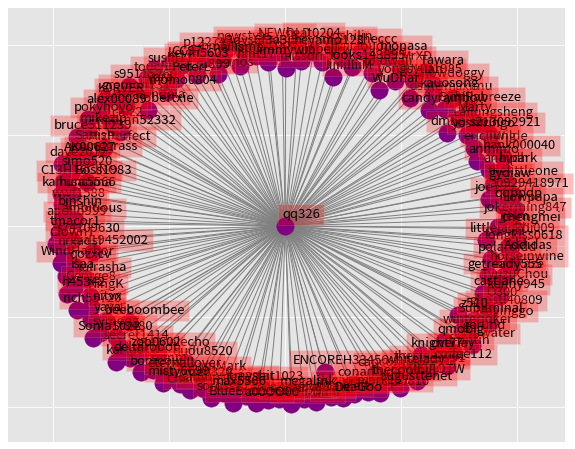

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 5.2 資料篩選
資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

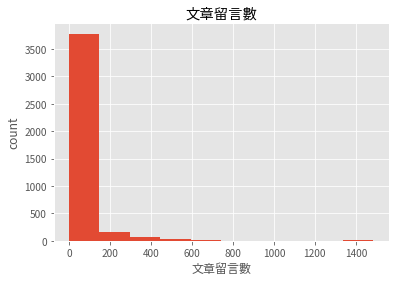

In [ ]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

依據發文數或回覆數篩選post和review

In [ ]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
1570,poppylove,25
190,ILike58,16
1583,protoss,15
444,VVizZ,15
734,chirex,15
...,...,...
1155,johnny811025,1
1154,john5380,1
438,URaybaobao,1
1152,jo4,1


In [ ]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 2055
回覆者數量總共: 25950


#### 標記所有出現過的使用者
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [ ]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [ ]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [ ]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replyer")

In [ ]:
allPoster.head(5)

,user,type
0,ironfox,replyer
1,assa9647,poster
2,andy092032,replyer
3,vgil,replyer
4,ryuhuang,replyer


### 5.3 以日期篩選社群

+ 12/17 深夜，李靚蕾發長文爆料王力宏出軌、召妓、私生活混亂
+ 12/18 後， Yumi、彈頭事件延燒<br>
因此，我們挑出21日的文章和回覆

In [ ]:
# 篩選日期為2021-12-21 且 留言數>200的文章
posts_Reviews_1221 = (posts_Reviews.query('artDate == "2021-12-21"')
                      .query('commentNum>200')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [ ]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_1221 = posts_Reviews_1221.query('size>5')
posts_Reviews_1221.head(3)

,cmtPoster,artUrl,size
39,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640085024....,19
40,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640089233....,14
123,CVIVIC,https://www.ptt.cc/bbs/Gossiping/M.1640105325....,11


In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1221 = pd.merge(posts_Reviews_1221,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1221.reset_index(inplace=True, drop=True) #重設index
link_1221.head(3)

,cmtPoster,artUrl,size,artPoster
0,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640085024....,19,yochiya
1,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640089233....,14,DuDu
2,CVIVIC,https://www.ptt.cc/bbs/Gossiping/M.1640105325....,11,DALUGI


In [ ]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_1221)):
    G.add_edge(link_1221["cmtPoster"][i], link_1221["artPoster"][i])

#### 加上nodes的顯示資訊
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

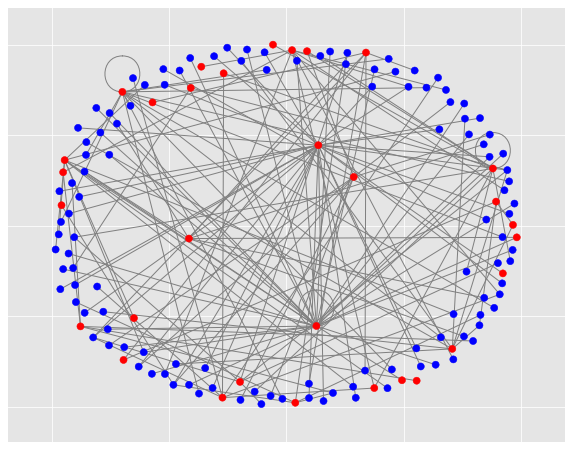

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。 

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['zkowntu', 'ILike58', 'cynthia12708']

In [ ]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

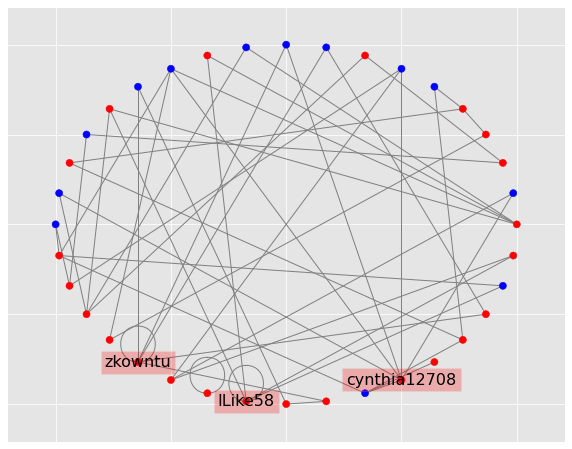

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

#### 計算Centrality  
找出重要的點  

In [ ]:
# degree centrality
degree = nx.degree_centrality(G)

In [ ]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [ ]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

In [ ]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [ ]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['zkowntu', 'ILike58', 'cynthia12708', 'yochiya', 'DALUGI']
eigenvector centrality: ['cynthia12708', 'zkowntu', 'soria', 'ILike58', 'yochiya']
pagerank centrality: ['zkowntu', 'cynthia12708', 'ILike58', 'NICKSHOW', 'DALUGI']
betweenness centrality: ['cynthia12708', 'pchome321', 'zkowntu', 'soria', 'NICKSHOW']


### 5.4 以主題篩選社群

挑選出2021-12-21當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於200則， 文章主題歸類為0(張惠妹)、1(離婚事件)與2(Yumi、彈頭延伸案件)， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [ ]:
# 加上topic
topic_1221 = pd.merge(link_1221,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1221_topic = pd.merge(topic_1221,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1221_topic.reset_index(inplace=True, drop=True) #重設index
link_1221_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640085024....,2,yochiya
1,AlohaVC,https://www.ptt.cc/bbs/Gossiping/M.1640089233....,2,DuDu
2,CVIVIC,https://www.ptt.cc/bbs/Gossiping/M.1640105325....,1,DALUGI


In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_1221_topic)):
    G.add_edge(link_1221_topic["cmtPoster"][i], link_1221_topic["artPoster"][i])
    if link_1221_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:張惠妹相關
    elif link_1221_topic["topic"][i] == 1:
        color_map_edge.append('green') # 主題一:離婚、小孩相關
    else: 
        color_map_edge.append('grey') # 主題三:相關人物，Yumi、彈頭相關

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

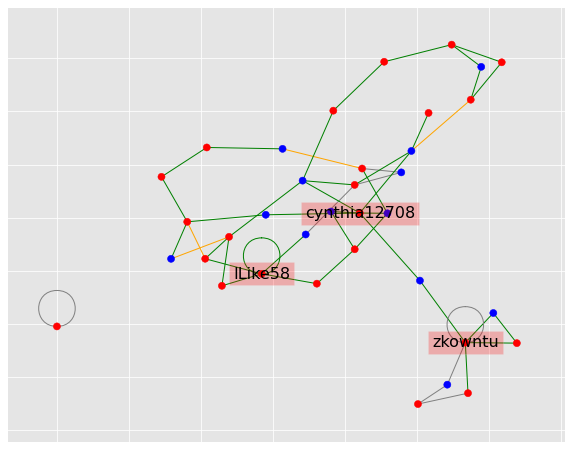

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

+ 橘色: 張惠妹相關
+ 綠色: 王力宏、李靚蕾離婚、小孩議題相關
+ 灰色: Yumi、彈頭相關

可以看出:
+ cynthia12708、ILike58 較多為雙方離婚和小孩的相關留言
+ zkowntu 較多為雙方離婚和延伸人物兩個主題的相關留言

### 5.5 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [ ]:
# 加上status
status_1221 = pd.merge(link_1221,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1221 = status_1221[status_1221["cmtStatus"]!="→"]

In [ ]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1221_status = pd.merge(status_1221,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1221_status.reset_index(inplace=True, drop=True) #重設index
link_1221_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,DCHC,https://www.ptt.cc/bbs/Gossiping/M.1640075388....,2,推,Scorpio
1,DinoZavolta,https://www.ptt.cc/bbs/Gossiping/M.1640109456....,1,推,zkowntu
2,DinoZavolta,https://www.ptt.cc/bbs/Gossiping/M.1640109456....,1,噓,zkowntu


In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1221_status)):
    G.add_edge(link_1221_status["cmtPoster"][i], link_1221_status["artPoster"][i])
    if link_1221_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [ ]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [ ]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replyer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [ ]:
# 找出degree>3的點
degrees = [node for (node, val) in G.degree() if val>3]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

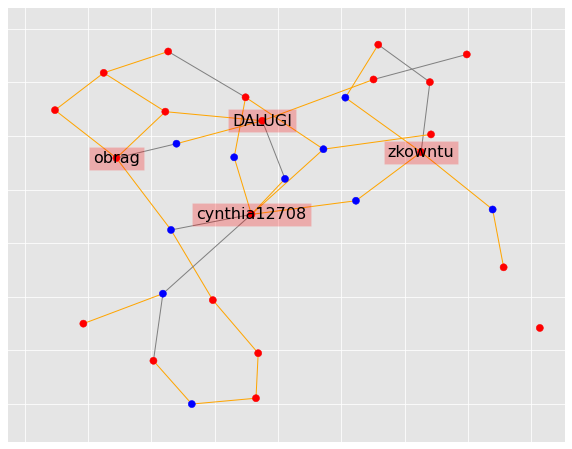

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

可以發現本次的討論中幾乎都是推文、噓文較少